# OSSEN Tutorial-Elsa Arcaute: Active Travel Accessibility Modelling and Connectivity Percolation in Greater London
This notebook demonstrates how to model active travel accessibility, i.e., walking and cycling, in Greater London using R5Py. Furthermore, It also includes a network percolation clustering analysis (Arcaute et al., 2016) to identify the connectivity of active travel network based on travel time thresholds.

Authors:
- Elsa Arcaute (e.arcaute@ucl.ac.uk)
- Xiuning Zhang (xiuning.zhang.23@ucl.ac.uk)
- Miao Zeng (miao.zeng.19@ucl.ac.uk)

## Introduction
Active travel, such as walking and cycling, is an essential part of sustainable urban mobility. It can help to reduce traffic congestion, improve air quality, and promote public health. This idea is being incorporated as a key concept in the 15-minute city, which aims to create neighbourhoods where people can access all their daily needs within a 15-minute walk or cycle.

For urban and transportation planning, the connectivity of active travel networks is crucial to ensure that people can easily access key destinations, such as schools, workplaces, and public amenities. A connected active travel accessibility network, e.g., in 15-minute's walk, can help to create a more liveable and sustainable city, and prevent the conspriracy of the 'limiting freedom to move' in the city.

In this tutorial, we will demonstrate how to model active travel accessibility in Greater London using R5Py, a Python wrapper for the R5 routing engine. Moreover, we will perform a percolation clustering analysis to identify the connectivity of active travel networks based on travel time thresholds. This analysis can help to identify the most connected areas and the connections between them.

## Part I Urban Network
The 1st part of this tutorial, we will learn one specific kind of urban networks —— the street networks:
1. Understand how to represent the street system as network.
2. Learn to use the OSMnx library.

### 1.Represent Street Network as Graph
![street network representation](street_networks.png)

from: [Street Network Studies: from Networks to Models and their Representations](https://link.springer.com/article/10.1007/s11067-018-9427-9)

###  2.the OSMnx library
It is a python library to help you download and analyze spatial data from OpenStreetMap.
https://osmnx.readthedocs.io/en/stable/

OSMnx is built on top of GeoPandas, and Networkx:
* Downloads and creates a networkx graph ofstreet networks or other infrastructure networks
    * Automatically cleans(topologically corrects) the network for you.
* Download any other spatial geometries (buildings, POI's, place **boundaries**)

#### **Step 1** Install & Import Librarie

In [ ]:
pip install networkx

In [ ]:
pip install osmnx

In [79]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### **Step 2** Acquire Street Network

In [ ]:
# We can build a graph by giving the name of the place
G = ox.graph_from_place('Oxford, England, United Kingdom', network_type='drive')
print(type(G))

In [ ]:
fig, ax = ox.plot_graph(G)

In [ ]:
# We can also build a graph by giving the coordinates and a radius
# ucl = (51.5245593,-0.1358805)

Uni_Oxford = (51.7570,-1.2545)
radius = 1500 #meters
G = ox.graph_from_point(Uni_Oxford, dist=radius, network_type='drive')
fig, ax = ox.plot_graph(G)

In [ ]:
# We can also get other infrastructure networks
# change the overpass query to meet the new style 'New York, NY, USA'
G = ox.graph_from_place('Greater London, England, United Kingdom',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=2, edge_color='w', edge_linewidth=0.2)


#### **Step 3** Simplify the Street Network

now onto community detection in street networks

to keep it light, we will only be using the city of London

In [ ]:
#get the street network in the University of Oxford
place = 'Oxford, England, United Kingdom'

# I'm setting simplify false here to show how osmnx clean the networks topology
G = ox.graph_from_point(Uni_Oxford, dist=radius, network_type='drive', simplify=False)
fig, ax = ox.plot_graph(G)
# G = ox.simplify_graph(G)

In [ ]:
nc = ['r' if ox.simplification._is_endpoint(G, node, None) else 'grey' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

In [ ]:
# simplify the network
fig, ax = plt.subplots(figsize=(12,7))
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G,
                        node_color='k',
                        node_size = 10,
                        ax=ax)

In [ ]:
# we can calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats

#### **Step 4** Acquire Other Spatial Data

In [ ]:
# get building footprints for the University of Oxford
buildings = ox.geometries_from_point(Uni_Oxford, dist=radius,tags={'building':True})
# get amenities for the University of Oxford
amenities = ox.geometries_from_point(Uni_Oxford,dist=radius,tags={'amenity':True, 'geometry':'point'})


In [ ]:
ax = buildings.plot(column='building', figsize=(20, 20), legend=True)
ax.set_axis_off()

#### **Step 5** Navigation & Routing

In [ ]:
current_B = buildings[buildings.name.str.contains("Department of Statistics", na=False)].geometry.centroid
destination = amenities[amenities.name.str.contains("Lady Margaret Hall", na=False)].geometry.centroid
print(current_B)
print(destination)

# get the nearest node to the centroid of St Paul's Cathedral
current_B = ox.nearest_nodes(G, current_B.x[0], current_B.y[0])
print(current_B)
# get the nearest node to the centroid of Lloyd's of London
destination = ox.nearest_nodes(G, destination.x[0], destination.y[0])
print(destination)

# get the shortest path between the two nodes
route = nx.shortest_path(G, current_B, destination, weight='length')

# plot the route
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k', subplot_kw=dict(aspect='equal'))

# clean it up
ax.set_facecolor('k')
ax.set_axis_off()

# add a title
ax.set_title('Shortest route between current building and Destination', fontsize=20, color='w', fontweight='bold')

buildings.plot(color='w', ax=ax)
ox.plot_graph_route(G, route, node_size=2, ax=ax)



In [ ]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [ ]:
# get pairs in route in moving window of 2
pairs = [(route[i], route[i+1], 0) for i in range(len(route)-1)]

# the edges index has this weird format, with u, v (for nodes) and then an odd 0
print(edges.index[0])
# so we match it
print(pairs[0])
# # osmnx also has a function to do this, but you're better than that
# pairs = ox.utils_graph.get_route_edge_attributes(G, route, 'length')

# look up the edge data for each pair using the 2 index values u, v
paths = edges[edges.index.isin(pairs)]

# how long is the journey?
paths['length'].sum()

# now we can add distances like this into our gravity models

**Exercise**

Now that we have shown you how to build a query to Open Street Map using `custom_filter`, see if you can do one yourself for the city of your choosing.

1. Look at this [table](https://wiki.openstreetmap.org/wiki/Map_features) that shows the names of OSM features
2. Substitute some of those into the query above
4. Make sure do one query that gets amenities, like restaurants or cafes and do another for a class of road

Hit: points of interest, like amenities, come from `geometries_from_*` rather than `graph_from_*`. Use the "tags" field to choose what kinds of features you want to download in this function.

---

Something the may be important to your work will be distinguishing "motorway", "primary", "secondary", "tertiary" roads as well as downloading "footpath". Another thing that OSMnx can do is download amenities, which is important to spatial interaction modelling: amenities can take the place of population at destination when we try to model the attractiveness.




## Part II Community Detection

### 1.Different Community Detection Algorithms

**CDlib**：  a Python library designed for discovering and analyzing communities in complex networks, which offer you different algorithms of community detections. Here we will use the Walktrap community detection algorithm as an example.


**The Walktrap community detection algorithm** identifies communities in a network by performing short random walks, where nodes that are visited together frequently are more likely to belong to the same community.

In [ ]:
pip install cdlib

In [ ]:
from cdlib import algorithms
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community.quality import partition_quality

In [ ]:
# let's use random walk, as it's fairly intuive in this setting
partitions = algorithms.walktrap(G)
neighbourhoods = partitions.communities

In [ ]:
# let us print some basic states about the communities found
n_comm = len(neighbourhoods)
mod = modularity(G, neighbourhoods)

#performance does not take multigraph
G_collapsed = ox.utils_graph.get_digraph(G, weight='length')
performance = partition_quality(G_collapsed, neighbourhoods)
print(f"""
{n_comm} communities found
modularity: {mod}
performance: {performance}
""")

let's plot to get a better idea of

In [ ]:
# let's build a dictionary with nodes as keys and cluster assignment
node_assignment = {}
for cluster, neighbourhood in enumerate(neighbourhoods):
    for node in neighbourhood:
        node_assignment[node] = cluster

In [ ]:
nx.set_node_attributes(G, node_assignment, 'cluster')

In [ ]:
cls = ox.plot.get_node_colors_by_attr(G, 'cluster', cmap='tab20')

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

fig, ax = ox.plot_graph(G,
                        node_color=cls,
                        node_size = 25,
                        ax=ax)

### 2 Percolation analysis
This section will apply percolation clustering analysis to the street network.

Percolation studies how a piece of information spreads in space, reaching a critical point at which a giant cluster appears. In its most general form, the process is defined in an infinite lattice and for a random occupation probability. Relaxing these constraints, the analysis can be extended to finite systems, where the clusters are the outcome of some thresholding process (Aharony, 2018).

The percolation process on networks can be depicted as follows:

![Schematic diagram of two types of percolation processes (Li et al., 2021)](https://github.com/xnzhang-33/OSSEN-Workshop/blob/main/@li2021a.png?raw=1)

a) is percolation on bonds (edges), as the vertices below threshold will be deleted and connected components will be clustered; b) is percolation on sites (vertices), as the vertices below threshold will be deleted and connected components will be clustered.

Some examples of percolation in urban contexts include the spread of diseases, the propagation of information, or the connectivity of transportation networks. It can be used to identify vulnerable areas, critical connections, or the most connected regions in a network (Li et al., 2021).

The percolation process can be integrated with a clustering algorithm similar to City Clustering Algorithm (Rozenfeld et al., 2008), which identifies the connected areas as a cluster within a certain threshold. But instead of single threshold, the clustering process can be applied to multiple thresholds to identify the clusters of areas and critical connections under different scenarios (Arcaute et al., 2016).  

In the context of active travel accessibility, it can be used to identify the clusters of areas that are connected within a certain travel time threshold. The percolation threshold is the point at which the network transitions from a collection of isolated clusters to a single connected cluster. This method can help to identify the most accessible areas and the connections between them.

#### **Step 1** Import

In [ ]:
import networkx as nx  # 对应于 igraph
import pandas as pd  # 对应于 reshape2 和 plyr
import geopandas as gpd  # 对应于 rgdal
from osgeo import gdal  # 对应于 rgdal

#### **Step 2** Get A Graph

In [ ]:
#get the street network in the University of Oxford
place = 'Oxford, England, United Kingdom'

# I'm setting simplify false here to show how osmnx clean the networks topology
G1 = ox.graph_from_place(place, network_type='drive', simplify=False)
fig, ax = ox.plot_graph(G1)


In [ ]:
# simplify the network
G1 = ox.simplify_graph(G1)
fig, ax = plt.subplots(figsize=(12,7))
fig, ax = ox.plot_graph(G1,
                        node_color='k',
                        node_size = 10,
                        ax=ax)

#### **Step 3** Transform to A Undirected Graph

In [ ]:
# convert your MultiDiGraph to an undirected MultiGraph
G2 = ox.convert.to_undirected(G1)

fig, ax = plt.subplots(figsize=(12,7))
fig, ax = ox.plot_graph(G2,
                        node_color='k',
                        node_size = 10,
                        ax=ax)

#### **Step 4** Check Edges & Nodes

In [ ]:
# From Graph to GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G1)
edges

In [ ]:
nodes

In [ ]:
# From Graph to GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G2)
edges

In [ ]:
nodes

In [ ]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# You can customize the plot with different options
edges.plot(ax=ax, color='blue', edgecolor='black')

# Optionally, you can add titles and labels
ax.set_title('Geospatial Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_axis_off()

# Show the plot
plt.show()

In [ ]:
data_coords = nodes[["x","y"]]
data_coords

# edgelist = edges[['from', 'to', 'length','geometry']]
# edgelist

In [ ]:
data_coords['id_point'] = data_coords.index
data_coords

In [ ]:
# 检查'row_name'列的数据类型
print("row_name列的数据类型：", data_coords['id_point'].dtype)

#### **Step 5** Percolation
The process consists of a series of thresholdings of the network, in which weak links get disconnected. For each threshold, different subgraphs emerged as the network starts to disconnect. The thresholds are NOT universal. Note that the networks from the OMS are incomplete, hence more detail, referring to smaller streets being present, will only be given in cities where the effort to map those streets has been put into it. Hence, different distances will be found for the transitions in different cities, and these might be given just by a problem of data resolution.

First let us define the vector containing the percolation thresholds of interest

First let us define the vector containing the percolation thresholds of interest

In [ ]:
import numpy as np

rmin = 10
rmax = 311
r0 = np.arange(rmin, rmax, 10)
n_loops = len(r0)

file_clust_size = 'cluster_size.txt'
with open(file_clust_size, 'w') as file:
    file.write('threshold\t size\n')

In [ ]:
n_loops

In [ ]:
r0

Define the thresholds to plot the maps

In [ ]:
# import matplotlib.pyplot as plt

# # Define the colors for the top 10 clusters
# top10 = [plt.cm.tab20c(i) for i in [19, 1, 11, 29, 4, 5, 22, 2, 3, 0]]

# top10
top10 = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'pink', 'cyan', 'magenta', 'brown']
top10

In [ ]:
# Visualize the colors
plt.bar(range(1, 11), range(1, 11), color=top10)
plt.show()

In [ ]:
jumps_2plot = [90, 150, 190, 200,310]
# jumps_2plot = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

In [ ]:
# 获取图的节点数
size_net = G2.number_of_nodes()
size_net

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

for i_t in r0:
    # Find subgraph such that all weights <= threshold r0
    edges = [(u, v, d) for u, v, d in G2.edges(data=True) if d['length'] <= i_t]
    g = nx.Graph()
    g.add_edges_from(edges)
    g.remove_nodes_from(list(nx.isolates(g)))

    # Take subcomponents
    membclusters = {node: cid for cid, component in enumerate(nx.connected_components(g)) for node in component}

    m = pd.DataFrame(list(membclusters.items()), columns=["id_point", "id_cluster"])

    # File for membership table for each threshold
    #file_name = f"{dir_memb}/London_p{i_t}.txt"
    #m.to_csv(file_name, index=False)

    table_data = m['id_cluster'].value_counts()

    # Largest connected component
    LCC = table_data.max()
    LCC_p = LCC / size_net
    v_LCC = [i_t, LCC, LCC_p]

    if i_t == rmin:
        v_LCC_t = np.array([v_LCC])
    else:
        v_LCC_t = np.vstack([v_LCC_t, v_LCC])

    sorted_table = table_data.sort_values(ascending=False)
    # file_out = f"{file_n_clust}{i_t}.csv"
    # sorted_table.to_csv(file_out, header=['id_cluster', 'n_points'], index=False)

    # Let us construct at the same time the file with the largest cluster size, i.e. connected component.
    with open(file_clust_size, 'a') as file:
        file.write(f"{i_t},{LCC}\n")

    if i_t in jumps_2plot:
        # Assign colours
        list_clusts = sorted_table.reset_index()
        list_clusts.columns = ["id_cluster", "n_points"]
        list_clusts['colour'] = 'grey'
        list_clusts.loc[:9, 'colour'] = top10
        list_clusts['size'] = 0.1
        list_clusts.loc[:9, 'size'] = 0.2

        total_list = pd.merge(list_clusts, m, on="id_cluster")

        points_coords_cols = pd.merge(total_list, data_coords, on="id_point")
        # file_map = f"{dir_maps}/London_d{i_t}.png"

        # Save the maps
        # plt.savefig(file_map, height=850, width=1000)
        plt.figure(figsize=(10, 8), facecolor='black')
        plt.scatter(points_coords_cols['x'], points_coords_cols['y'], s=points_coords_cols['size'] * 100, c=points_coords_cols['colour'], edgecolor='none')
        plt.title(f"Oxford at d={i_t}m", color='white')
        plt.axis('off')
        plt.show()
        # plt.savefig(file_map)
        # plt.close()


In [ ]:
import matplotlib.pyplot as plt

# 设置背景颜色为白色
plt.figure(facecolor='white')

# 绘制图形
plt.scatter(v_LCC_t[:, 0], v_LCC_t[:, 1], c='black', s=5)  # s参数调整点的大小以匹配cex=0.5

# 添加网格
plt.grid(True)

# 添加标签和标题
plt.xlabel("distance")
plt.ylabel("size")
plt.title("Evolution of Largest Connected Component")

# 显示图形
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 假设 v_LCC_t 是一个 NumPy 数组
# v_LCC_t[:, 0] 对应于 R 中的 v_LCC_t[, 1]
# v_LCC_t[:, 2] 对应于 R 中的 v_LCC_t[, 3]

# 设置背景颜色为白色
plt.figure(facecolor='white')

# 绘制图形
plt.scatter(v_LCC_t[:, 0], v_LCC_t[:, 2], c='black', s=5)  # s参数调整点的大小以匹配cex=0.5

# 添加网格
plt.grid(True)

# 添加标签和标题
plt.xlabel("distance")
plt.ylabel("size")
plt.title("Evolution of Largest Connected Component normalised")

# 显示图形
plt.show()


## Part III Accessibility Modelling using R5Py

In [ ]:
!pip install r5py

In [ ]:
# Allow 8 GB of memory
import sys
sys.argv.append(["--max-memory", "8G"])

In [34]:
# R5Py for travel time matrix computation
from r5py import TransportNetwork, TravelTimeMatrixComputer

# GeoPandas for spatial data manipulation
import geopandas as gpd
import pandas as pd

In [83]:
# Import spatial boundaries of Oxford for context
ox_bound = gpd.read_file('spatial/oxford_boundary.geojson').to_crs(epsg=4326)

In [41]:
# Create the origins and destinations GeoDataFrame for calculating the travel time matrix
origins = gpd.read_file('spatial/oxford_points.geojson')
destinations_university = gpd.read_file('spatial/oxford_university_buildings_centroids.geojson')
destinations_food = gpd.read_file('spatial/oxford_food.geojson')

In [42]:
###### Create a TransportNetwork object in R5Py using the OSM data ######
transport_network = TransportNetwork(
    osm_pbf='r5/oxfordshire-latest.osm.pbf', # Path to the OSM PBF file
    gtfs=['r5/oxfordbus_1718780465.zip'] # Path to the GTFS file
)

### Time matrix and accessibility

In [112]:
origin = origins.loc[origins['id'] == 1308]

In [88]:
# Create a TravelTimeMatrixComputer object using R5Py to calculate travel times

# This is a key step as it will determine the travel times between all pairs of origins and destinations in the network
travel_time_computer_point = TravelTimeMatrixComputer(
    transport_network=transport_network,
    origins=origin,
    destinations=origins,
    snap_to_network=True,
    # Below are some of the travel options that can be tweaked as needed
    transport_modes=['WALK','BICYCLE', 'TRANSIT'], # Modes of transport to consider, e.g., 'WALK', 'BICYCLE', 'CAR', 'TRANSIT'
    # speed_walking=3.6,
)

# For more information on the available options, please refer to the R5Py documentation: https://r5py.readthedocs.io/en/latest/

In [89]:
# Compute travel times between all origins and destinations; This may take a while but is considerably faster than using API etc.
od_matrix_point = travel_time_computer_point.compute_travel_times()

In [90]:
join_point = origins.merge(od_matrix_point, left_on="id", right_on="to_id")
join_point.head()

,id,VALUE,geometry,from_id,to_id,travel_time
0,0,4.047740,POINT (-1.28333 51.79583),1308,0,27
1,1,1.973868,POINT (-1.28250 51.79583),1308,1,27
2,2,1.742770,POINT (-1.28167 51.79583),1308,2,27
3,3,1.543149,POINT (-1.28083 51.79583),1308,3,27
4,4,1.621427,POINT (-1.28000 51.79583),1308,4,27


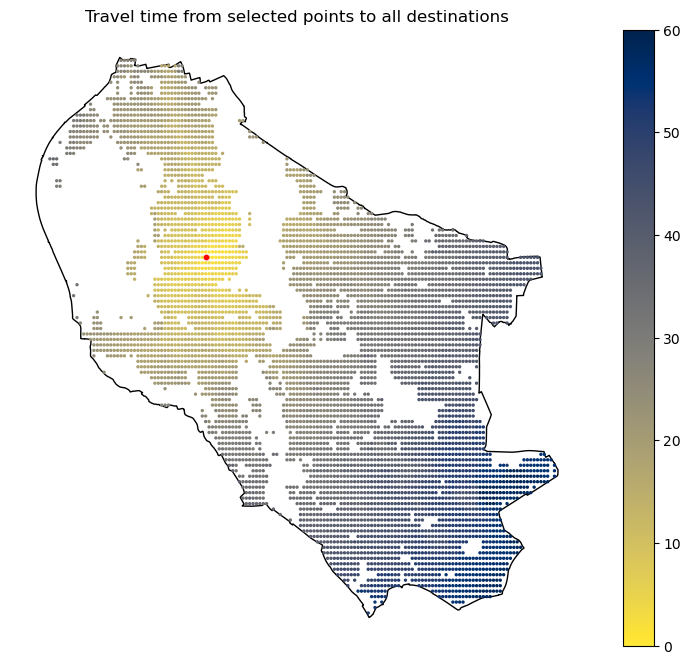

In [107]:
# Build a plot to show the travel times pairs
fig, ax = plt.subplots(figsize=(10,8))  # Adjust size as needed

# Plot the boundary for context
ox_bound.plot(ax=ax, color='none', scheme='natural_breaks', linewidth=1)
join_point.plot(ax=ax,column="travel_time", cmap="cividis_r",markersize=2,linewidth=1,legend=True)
origin.plot(ax=ax, color='red', markersize=10,legend=True)

ax.set_title("Travel time from selected points to all destinations")
ax.set_axis_off()

### Opportunities accessible within a certain travel time
It is important to understand the accessibility of urban amenities, such as food outlets, schools, and healthcare facilities, to different parts of the city. This information can help urban planners and policymakers identify areas with limited access to essential services and improve the overall accessibility of the city.

Similar case can be made for the accessibility of opportunities, such as jobs and schools. This section will be using the Oxford dataset to demonstrate how to calculate the accessibility of food outlets in the city using R5Py.

In this case, we will calculate the number of food outlets accessible within 25 minutes of sustainable travel (walking, cycling and public transport) from each population grid in Oxford.

In [64]:
travel_time_computer = TravelTimeMatrixComputer(
    transport_network=transport_network,
    origins=origins,
    destinations=destinations_food, #Here we use all the functions that serves food
    snap_to_network=True,
    transport_modes=['WALK','BICYCLE', 'TRANSIT'], 
)

In [65]:
od_matrix = travel_time_computer.compute_travel_times()
# od_matrix.head()

In [67]:
# Filter the OD matrix to include only travel times less than or equal to 25 minutes
filtered_matrix = od_matrix[od_matrix['travel_time'] <= 25]

# Count the number of accessible POIs for each population grid
accessible_pois = filtered_matrix.groupby('from_id').size().reset_index(name='access_foods')

# Merge the accessibility information with the origins GeoDataFrame for plotting
join = origins.merge(accessible_pois, left_on="id", right_on="from_id")

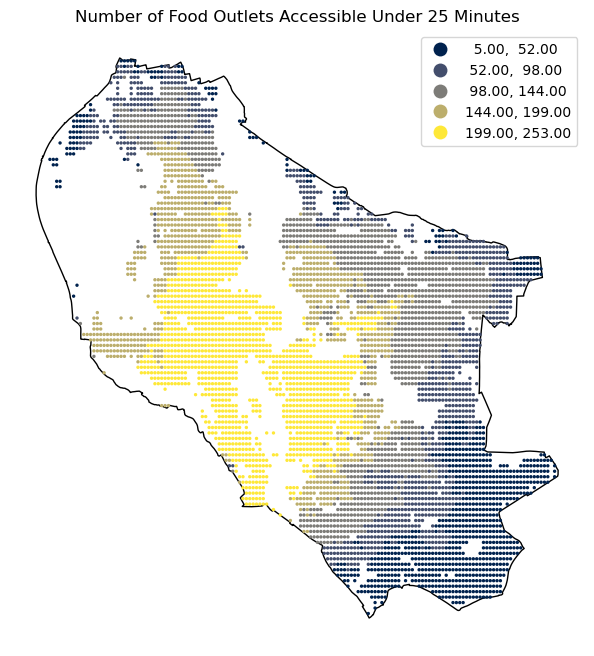

In [111]:
# Build a plot to show the travel times pairs
fig, ax = plt.subplots(figsize=(10,8))  # Adjust size as needed

# Plot the Oxford County boundary for context
ox_bound.plot(ax=ax, color='none', scheme='natural_breaks', linewidth=1)

# Plot the number of accessible food outlets aggregated in the above block
join.plot(ax=ax,column="access_foods", scheme='natural_breaks',cmap="cividis",markersize=2,linewidth=1, legend=True)

ax.set_title("Number of Food Outlets Accessible Under 25 Minutes")
ax.set_axis_off()